Numerical modeling requires validation, validation and more validation! In my work for my PhD I had to model a multidegree of freedom vibration problem. However, for confidence in the results I also need to compare it with a single degree of freedom to see how well it fares. So what better chance to learn how to solve differential equations in Julia! In this post I am learning how to use the DifferentialEquations package.

***

First some editorial work. The javascript code below will activate the display of the MathJax equation numbering.

%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

# The simple harmonic oscillator

The simple harmonic oscillator can be represented by a frictionless cart with mass, $m$, that moves in one dimension, $x$, hence single degree of freedom (SDOF). An excitation force, $F(t)$, is applied and the model is balanced by the stiffness, $k$, and damping, $c$, of the cart and connection. Based on the properties different dynamic phenomena can be observed.

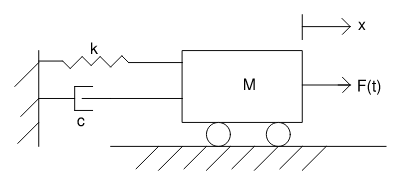

Written mathematically the above is expressed in Equation 1.

$$
\begin{equation}
m \frac{d^2 y}{d t^2} + c \frac{d y}{d t} + k y = f(t)
\end{equation}
$$

This is a non-homogeneous second order ordinary differential equation with constant coefficients (whew that was long). To solve it we can to reduce it to a first order differential equation. We can do this by writing Equation 1 as a system of equations shown in Equation 2 and 3.

$$
\begin{equation}
\begin{bmatrix}
m & 0\\
0 & 1\\
\end{bmatrix}
\begin{bmatrix}
\ddot{x}\\
\dot{x}
\end{bmatrix}
+
\begin{bmatrix}
c & k\\
-1 & 0\\
\end{bmatrix}
\begin{bmatrix}
\dot{x}\\
x
\end{bmatrix}
=
\begin{bmatrix}
f(t)\\
0
\end{bmatrix}
\end{equation}
$$

$$
\begin{equation}
\begin{aligned}
\dot{Y} &= \begin{bmatrix} \ddot{x}\\ \dot{x} \end{bmatrix}\\
Y &= \begin{bmatrix} \dot{x}\\ x \end{bmatrix}
\end{aligned}
\end{equation}
$$

We can now substitute Equations 2 and 3 into Equation 1 and obtain Equation 4.

$$
\begin{equation}
A\dot{Y} + BY = C
\end{equation}
$$

Next we need to define the matrices *A*, *B* and *C* from Equation 1 and 4.

In [37]:
A = [2. 0.
     0. 1.]
B = [0.01 0.1
     -1. 0.]
C = [1.
     0.];

Here we set the mass, $m=2$, damping, $c=0.01$ and stiffness, $k=0.1$.

Using **DifferentialEquations.jl** we can solve the ODE. I am also using the **DiffEqCallbacks.jl** package to call custom functions in order to implement the excitation force, $f(t)$.

In [44]:
using DifferentialEquations
using DiffEqCallbacks
using Plots

To solve the equation we can invert matrix **A**. This is really not a problem here since it is tiny. We also set the initial conditions which in our case are the speed, $dx/dt$ and the displacement, $x$.

In [45]:
sdof(y, p, t) = inv(A) * (-B * y + C)
u0 = rand(2, 1)
tspan = (0.0, 100.0);

Next we need to define the callback functions. The idea is that every time step $\delta t$ the functions will be called and update the excitation force. In **DiffEqCallbacks** this is done using a condition i.e. what causes the event and what effect it has. In our model we want the event to be called continuous which means we can use a simple function to always return true and the affect is to mutate the matrix **C**.

In [46]:
function condition(y, t, integrator)
    true
end

function affect!(integrator)
    C = [sin(2 * π * integrator.t)
         0.]
end

cb = ContinuousCallback(condition, affect!)

ContinuousCallback{typeof(condition),typeof(affect!),typeof(affect!),typeof(DiffEqBase.INITIALIZE_DEFAULT),Float64,Int64,Nothing}(condition, affect!, affect!, DiffEqBase.INITIALIZE_DEFAULT, nothing, true, 10, Bool[true, true], 2.220446049250313e-15, 0)

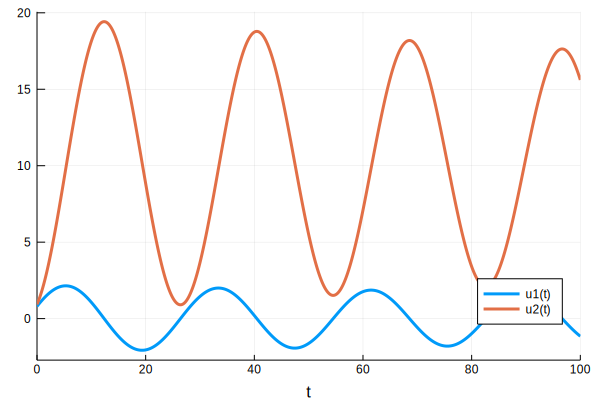

In [50]:
prob = ODEProblem(f, u0, tspan, callback = cb)
sol = solve(prob)
plot(sol, legend=:bottomright, format=:svg)

We can see as expected because of the damping the displacement, $u_2(t)$, is decreasing with time.

# Vibrating Beam

For the next part we need to solve more complicated problems. In particular for my application I need to model a simply supported beam with a uniform load which represents an explosion. To use the SDOF formulation we need to collate the structural and material properties into one dimension. The Problem we are modeling can be shown graphically below.

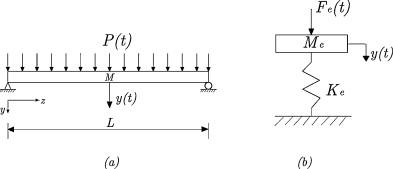

For the case of investigating a blast load the duration is too short and damping can be neglected, hence we are going to omit the $c$ term and balance the equation only with mass and stiffness. The second order ODE is then shown in Equation 5. The variables expressed with a bar on top mean that their effect has been summed over the length of the beam.

$$
\begin{equation}
\bar{m} \frac{\partial^2 y}{\partial t^2} + \bar{k} y = \bar{f}(t)
\end{equation}
$$

To carry out the summation we need to first assume a shape function. This means that we are imposing a predefined mode of vibration and calculating everything based off that. For a simple case as ours it is obvious that the beam would deflect downwards following a cosine function. If we express the stiffness using the structural and materials properties (Young's modulus and second moment of area) as $EI$ an dthe shape function as $\phi(x)$ we obtain the summation in Equation 6 to 9.

We can assume that the Young's modulus is $200 GPa$, the second moment of area $0.402 \times 10^{-3} m^4$, the mass per unit length $129 kg/m$ and the length $4 m$.

In [69]:
E = 200*10^9.
I = 0.40 *10^(-3)
m = 129.
L = 4.;

First we need to define the shape function and the derivatives. The function for our case is shown in Equation 6 and is simple for a hand calculation but here I am using the automatic differentiation method since I want to be able to explore more complex ones in the future.

$$
\begin{equation}
\phi(x) = 0.5 \left( 1-cos \left( \frac{2 \pi x}{L} \right) \right)
\end{equation}
$$

In [70]:
shapef(x::Float64) = 0.5 * (1 - cos(2πx/L))

shapef (generic function with 1 method)

The first and second derivatives can then be computed using automatic differentiation as:

In [71]:
using ForwardDiff

shapef_once = x -> ForwardDiff.gradient(shapef, x)
shapef_twice = x -> FowwardDiff.gradient(shapef_once, x)

#5 (generic function with 1 method)

Now we can can  the excitation force. We can assume that a blast load of 5 MPa has been applied of the top of the beam for 15 ms with a linearly decreasing magnitude.

In [73]:
function blast_load(t::Float64)
    if t <= 0.015
        return 5. * (0.015 - t)
    else
        return 0.
    end
end

blast_load (generic function with 1 method)

$$
\begin{equation}
\bar{f}(t) = \int_L^0 q(t) \phi(x) dx
\end{equation}
$$

$$
\begin{equation}
\bar{m} = \int_L^0 m \phi (x)^2 dx
\end{equation}
$$

$$
\begin{equation}
\bar{k} = \int_L^0 EI \frac{d^2 \phi}{d x^2} dx
\end{equation}
$$